In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from glob import glob

In [2]:
def prep_features(csv_feature):
    
    df = pd.read_csv(csv_feature)
    df.sort_index(axis=1, inplace=True)
    
    for c in df.columns:
        if 'Unnamed' in c:
            del df[c]
        elif 'depth' in c.lower():
            del df[c]
    
    df.replace(-9999, np.nan, inplace=True)
    df.dropna(inplace=True)
    
    Xdf = df.drop('Drift Status Label', axis=1)
    X = Xdf.values
    y = np.ravel(df.iloc[:, [1]])
    return X, y, Xdf

In [5]:
def rf_pipeline(X, y):

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     pipe_rf = Pipeline([('sc', MinMaxScaler(feature_range=(0, 0.9999))), #'sc', StandardScaler()),
#                         ('rf', RandomForestClassifier(
#                                                       n_estimators=50,
#                                                       oob_score=False,
#                                                       n_jobs=-1))])

    pipe_rf = Pipeline([('rf', RandomForestClassifier(
                                                      n_estimators=250,
                                                      oo b_score=False,
                                                      n_jobs=-1))])

    
    kfold = StratifiedKFold(n_splits=3)

    scores = []

    for train, test in kfold.split(X=X, y=y):
        a = pipe_rf.fit(X[[train]], y[[train]])
        score = pipe_rf.score(X[[test]], y[[test]])
        scores.append(score)
        print(score)
    
    print('Cross-Validation Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    
    return a.steps[0][1].feature_importances_

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/whorl_3_m_features.csv
0.488942467576
0.506318589957
0.636781864036
Cross-Validation Accuracy: 0.544 +/- 0.066


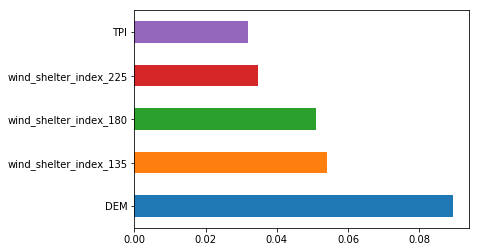

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/piute_3_m_features.csv
0.660594680941
0.693627038843
0.842465177545
Cross-Validation Accuracy: 0.732 +/- 0.079


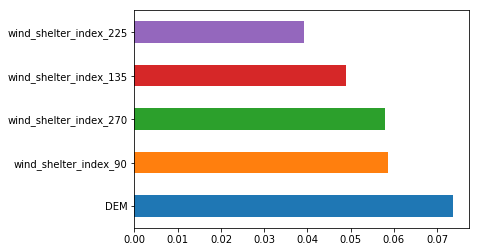

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/quarry_3_m_features.csv
0.72266068511
0.762918859042
0.771386634911
Cross-Validation Accuracy: 0.752 +/- 0.021


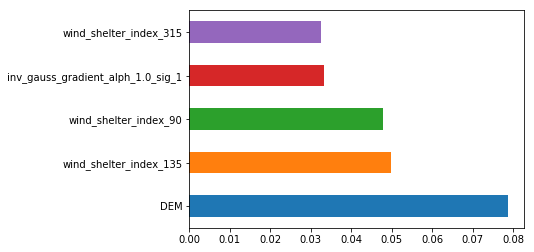

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/snowpeak_3_m_features.csv
0.523394813479
0.580157541466
0.702168968769
Cross-Validation Accuracy: 0.602 +/- 0.075


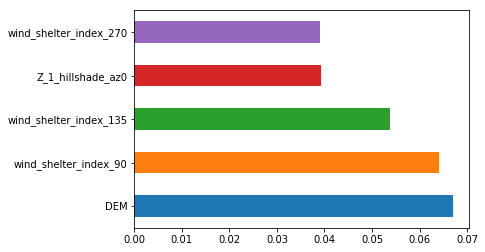

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/acker_3_m_features.csv
0.566282022968
0.594743816254
0.621279885153
Cross-Validation Accuracy: 0.594 +/- 0.022


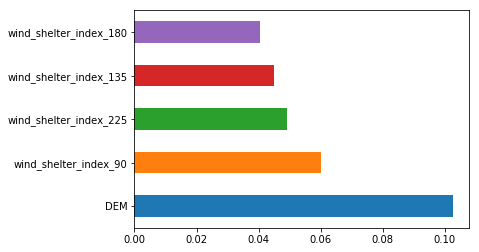

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/price_3_m_features.csv
0.637466839758
0.658961984591
0.790957581915
Cross-Validation Accuracy: 0.696 +/- 0.068


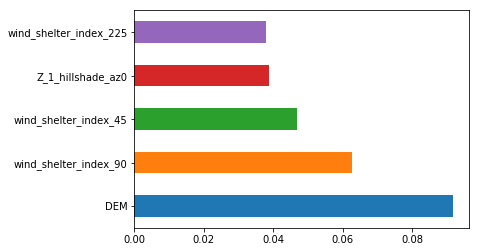

../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/johnson_3_m_features.csv
0.789346727964
0.826834667121
0.830996707912
Cross-Validation Accuracy: 0.816 +/- 0.019


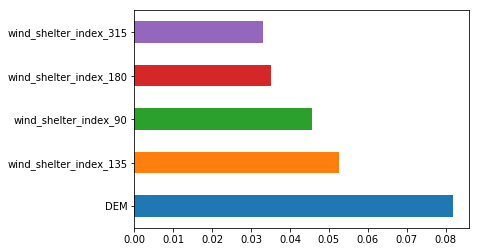

In [6]:
dir_path = '../random_forest_model/input_feature_data/tuolumne/three_meter/feature_csv_files/'

for file_name in glob(dir_path + '*.csv'):
    
    print(file_name)
    
    features = prep_features(file_name)
    weights = rf_pipeline(features[0], features[1])
    
    feat_importances = pd.Series(weights, index=features[2].columns)
    plt.figure()
    feat_importances.nlargest(5).plot(kind='barh')
    plt.show()

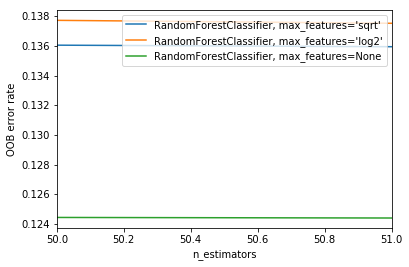

In [8]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

features = prep_features(file_name)

X = features[0]
y = features[1]

RANDOM_STATE = 123

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 51

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()